In [1]:
import numpy as np
import math
import sympy as sp
import matplotlib.pyplot as plt

X = np.array([0.01, 0.99, 2.02, 3.01, 3.97, 5.01, 5.93, 6.99, 8.08])
Y = np.array([0.1, 1.621, 1.782, 0.915, -0.122, -0.225, 1.099, 2.728, 3.534])

X2 = np.linspace(min(X), max(X) , 100)


**Aproximação por Mínimos Quadrados**

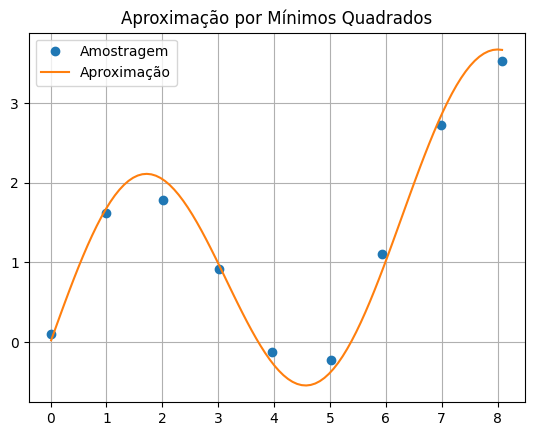

In [2]:
def least_squares(X, Y, f):
    n = range(len(f))
    
    A = np.zeros((max(n)+1, max(n)+1))
    b = np.zeros(max(n)+1)
    
    for i,j in ((i,j) for i in n for j in n):
        A[i, j] = np.sum(f[i](X) * f[j](X))
        b[i] = np.sum(f[i](X) * Y)
    
    A[0,0] = len(A)*len(A)

    a = np.linalg.solve(A, b)
    
    g = lambda x: sum(a[i] * f[i](x) for i in n)
    
    return a, g

f = [lambda x: np.sin(x), lambda x: x]

a, g = least_squares(X, Y, f)

Y2 = g(X2)

plt.plot(X, Y, 'o', label = 'Amostragem')
plt.plot(X2, Y2, '-', label = 'Aproximação')
plt.title('Aproximação por Mínimos Quadrados')
plt.legend()
plt.grid()
plt.show()


**Polinômio de Chebyshev**

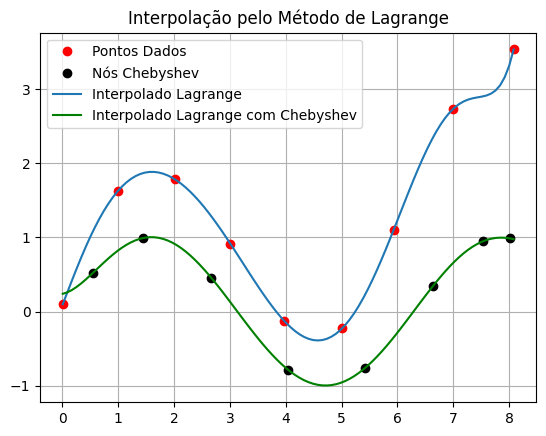

In [3]:
def chebyshev(a, b, n):
    return np.array([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n + 2)) for k in range(n)])

def lagrange(X, Y, x):
    n = len(X)
    p = 0.0
    for k in range(n):
        lk = 1.0
        for i in range(n):
            if k != i:
                lk *= (x - X[i]) / (X[k] - X[i])
        p += Y[k] * lk
    return p

X_chebyshev = chebyshev(min(X), max(X), len(X) - 1)
Y_chebyshev = np.sin(X_chebyshev)#[lagrange(X,Y,x) for x in X_chebyshev]

Y2 = [lagrange(X,Y,x) for x in X2]
Y3 = [lagrange(X_chebyshev,Y_chebyshev,x) for x in X2]

plt.plot(X, Y, 'ro', label = 'Pontos Dados')
plt.plot(X_chebyshev, Y_chebyshev, 'ko', label = 'Nós Chebyshev')
plt.plot(X2, Y2, '-', label = 'Interpolado Lagrange')
plt.plot(X2, Y3, 'g-', label = 'Interpolado Lagrange com Chebyshev')

plt.title('Interpolação pelo Método de Lagrange')
plt.grid()
plt.legend()
plt.show()


**Aproximação Racional de Padé**

In [4]:
def polynomial(x, p, q):
    P = np.polyval(p[::-1], x)
    Q = np.polyval(np.append(1, q)[::-1], x)
    return P / Q

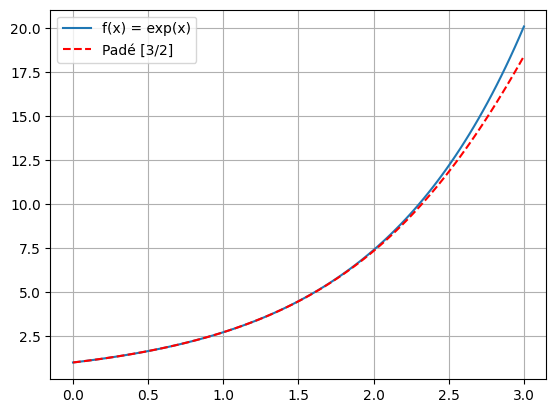

In [5]:
def mclaurin(f, n):
    x = sp.symbols('x')
    f_taylor = f(x)
    
    a = [f_taylor.subs(x, 0)]
    for i in range(1, n):
        f_taylor = sp.diff(f_taylor, x)
        a.append(f_taylor.subs(x, 0) / math.factorial(i))
    
    return np.array(a, dtype = float)

def pade_approximation(f, x, n, m):
    a = mclaurin(f, n + m + 1)
    
    A = np.zeros((m, m))
    B = np.zeros(m)
    
    for i in range(m):
        B[i] = -a[n + i + 1]
        for j in range(m):
            A[i, j] = a[n + i - j]
    
    q = np.linalg.solve(A, B)
    
    p = np.zeros(n + 1)
    p[0] = a[0]
    
    for i in range(1, n + 1):
        s = sum(q[j] * a[i - j - 1] for j in range(min(i, m)))
        p[i] = a[i] + s
    

    return polynomial(x, p, q)

f = lambda x: sp.exp(x)
n, m = 3 , 2

x = np.linspace(0, 3, 100)
y_pade = pade_approximation(f, x, n, m)
y = [f(xi) for xi in x]

plt.plot(x, y, label = "f(x) = exp(x)")
plt.plot(x, y_pade, 'r--', label = f'Padé [{n}/{m}]')
plt.legend()
plt.grid()
plt.show()

**Aproximação Racional de Chebyshev**

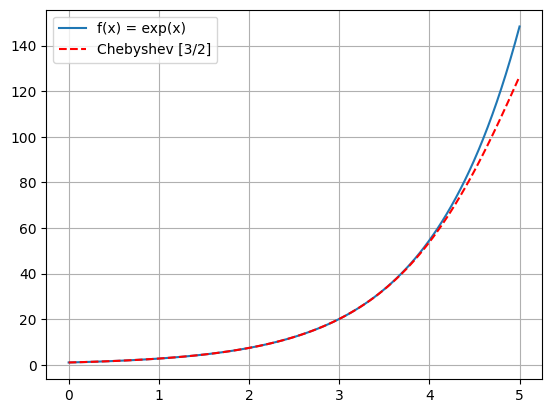

In [6]:
from scipy.optimize import minimize

def chebyshev_nodes(k, N, a, b):
        return 0.5 * ((b - a) * np.cos((2 * k - 1) * np.pi / (2 * N)) + (b + a))

def chebyshev_approximation(f, x, n, m, interval):
    a, b = interval
    N = n + m + 1
    nodes = np.array([chebyshev_nodes(k, N, a, b) for k in range(1, N + 1)])
    
    # Calcula a matriz de Vandermonde e o vetor f(nodes)
    A = np.zeros((N, n + m + 1))
    for i in range(N):
        for j in range(n + 1):
            A[i, j] = nodes[i] ** j
        for j in range(m):
            A[i, n + 1 + j] = -f(nodes[i]) * nodes[i] ** (j + 1)
    
    b = np.array([f(nodes[i]) for i in range(N)])
    
    # Resolve o sistema para encontrar os coeficientes
    coeffs = np.linalg.lstsq(A, b, rcond=None)[0]
    p = coeffs[:n + 1]
    q = coeffs[n + 1:]
    
    return polynomial(x, p, q)

f = lambda x: np.exp(x)
n, m = 3, 2
interval = (0, 3)

x = np.linspace(0, 5, 100)
y_chebyshev = chebyshev_approximation(f, x, n, m, interval)
y = [f(xi) for xi in x]

plt.plot(x, y, label = "f(x) = exp(x)")
plt.plot(x, y_chebyshev, 'r--', label = f'Chebyshev [{n}/{m}]')
plt.legend()
plt.grid()
plt.show()


**Série de Fourier**

In [7]:
def fft(m, p, y):
    M = m
    q = p    
    e = np.exp(-1j * 2 * np.pi / m) 

    a = np.zeros_like(y)
    b = np.zeros_like(y).astype(complex)
    c = np.copy(y).astype(complex)

    xi = np.zeros(2*M).astype(complex)
    
    for i in range(M):
        xi[i] = e ** i 
        xi[i+M] = -xi[i]

    def bit_reversal(x, n):
        result = 0
        for i in range(n):
            result = (result << 1) | (x & 1)
            x >>= 1
        return result

    K = 0
    for L in range(1, p + 2):
        while K < 2 * m - 1:
            for j in range(1, M + 1):
                K_binario = [int(x) for x in bin(K)[2:]]  
                K_binario = [0] * (p + 1 - len(K_binario)) + K_binario
                k = K_binario[::-1]

                K1 = sum(k[p-i] * (2 ** (p-i-q)) for i in range(q+1))
                K2 = sum(k[q+i] * (2 ** (p-i)) for i in range(p-q+1))

                eta = c[K + M] * xi[K2] 
                c[K + M] = c[K] - eta
                c[K] = c[K] + eta

                K += 1
            K += M
        K = 0
        M = M // 2
        q -= 1

    while K < 2 * m - 1:
        K_binario = [int(x) for x in bin(K)[2:]]  
        K_binario = [0] * (p + 1 - len(K_binario)) + K_binario
        k = K_binario[::-1]

        j = bit_reversal(K, p + 1)

        if j > K: 
            c[j], c[K] = c[K], c[j]

        K += 1

    a[0] = np.real(c[0]) / m
    a[m] = np.real(np.exp(-1j * np.pi * m) * c[m]) / m

    for j in range(1, m):
        a[j] = np.real(np.exp(-1j * np.pi * j) * c[j]) / m
        b[j] = np.imag(np.exp(-1j * np.pi * j) * c[j]) / m
    
    return c, a, b

p = 1
m = 2**p

f = lambda x: 2*x**2 - 9

x = [-np.pi + j*(np.pi/ m) for j in range(2*m)]  
y = [f(xi) for xi in x]  

c, a, b = fft(m, p, y)

print("Componentes reais a:", a)
print("Componentes imaginários b:", b)


Componentes reais a: [-3.1955934 -9.8696044  4.9348022  0.       ]
Componentes imaginários b: [ 0.00000000e+00+0.j -1.20867794e-15+0.j  0.00000000e+00+0.j
  0.00000000e+00+0.j]
